### Import Packages

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read in Data

In [84]:
# read in csv as dataframe
raw_df = pd.read_csv('tr_eikon_eod_data.csv', parse_dates=True, index_col=0)
stocks = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
data = raw_df[stocks]

# split into train and test set
n = int(len(data)/2)
train = data.iloc[ :n ,:]
test = data.iloc[ n: ,:]


In [85]:
train

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-04,30.572827,30.950,20.8800,133.900,173.08
2010-01-05,30.625684,30.960,20.8700,134.690,176.14
2010-01-06,30.138541,30.770,20.8000,132.250,174.26
2010-01-07,30.082827,30.452,20.6000,130.000,177.67
...,...,...,...,...,...
2014-03-26,77.111351,39.790,25.3772,343.410,161.73
2014-03-27,76.779923,39.360,25.3100,338.470,162.29
2014-03-28,76.694209,40.300,25.6200,338.290,162.30


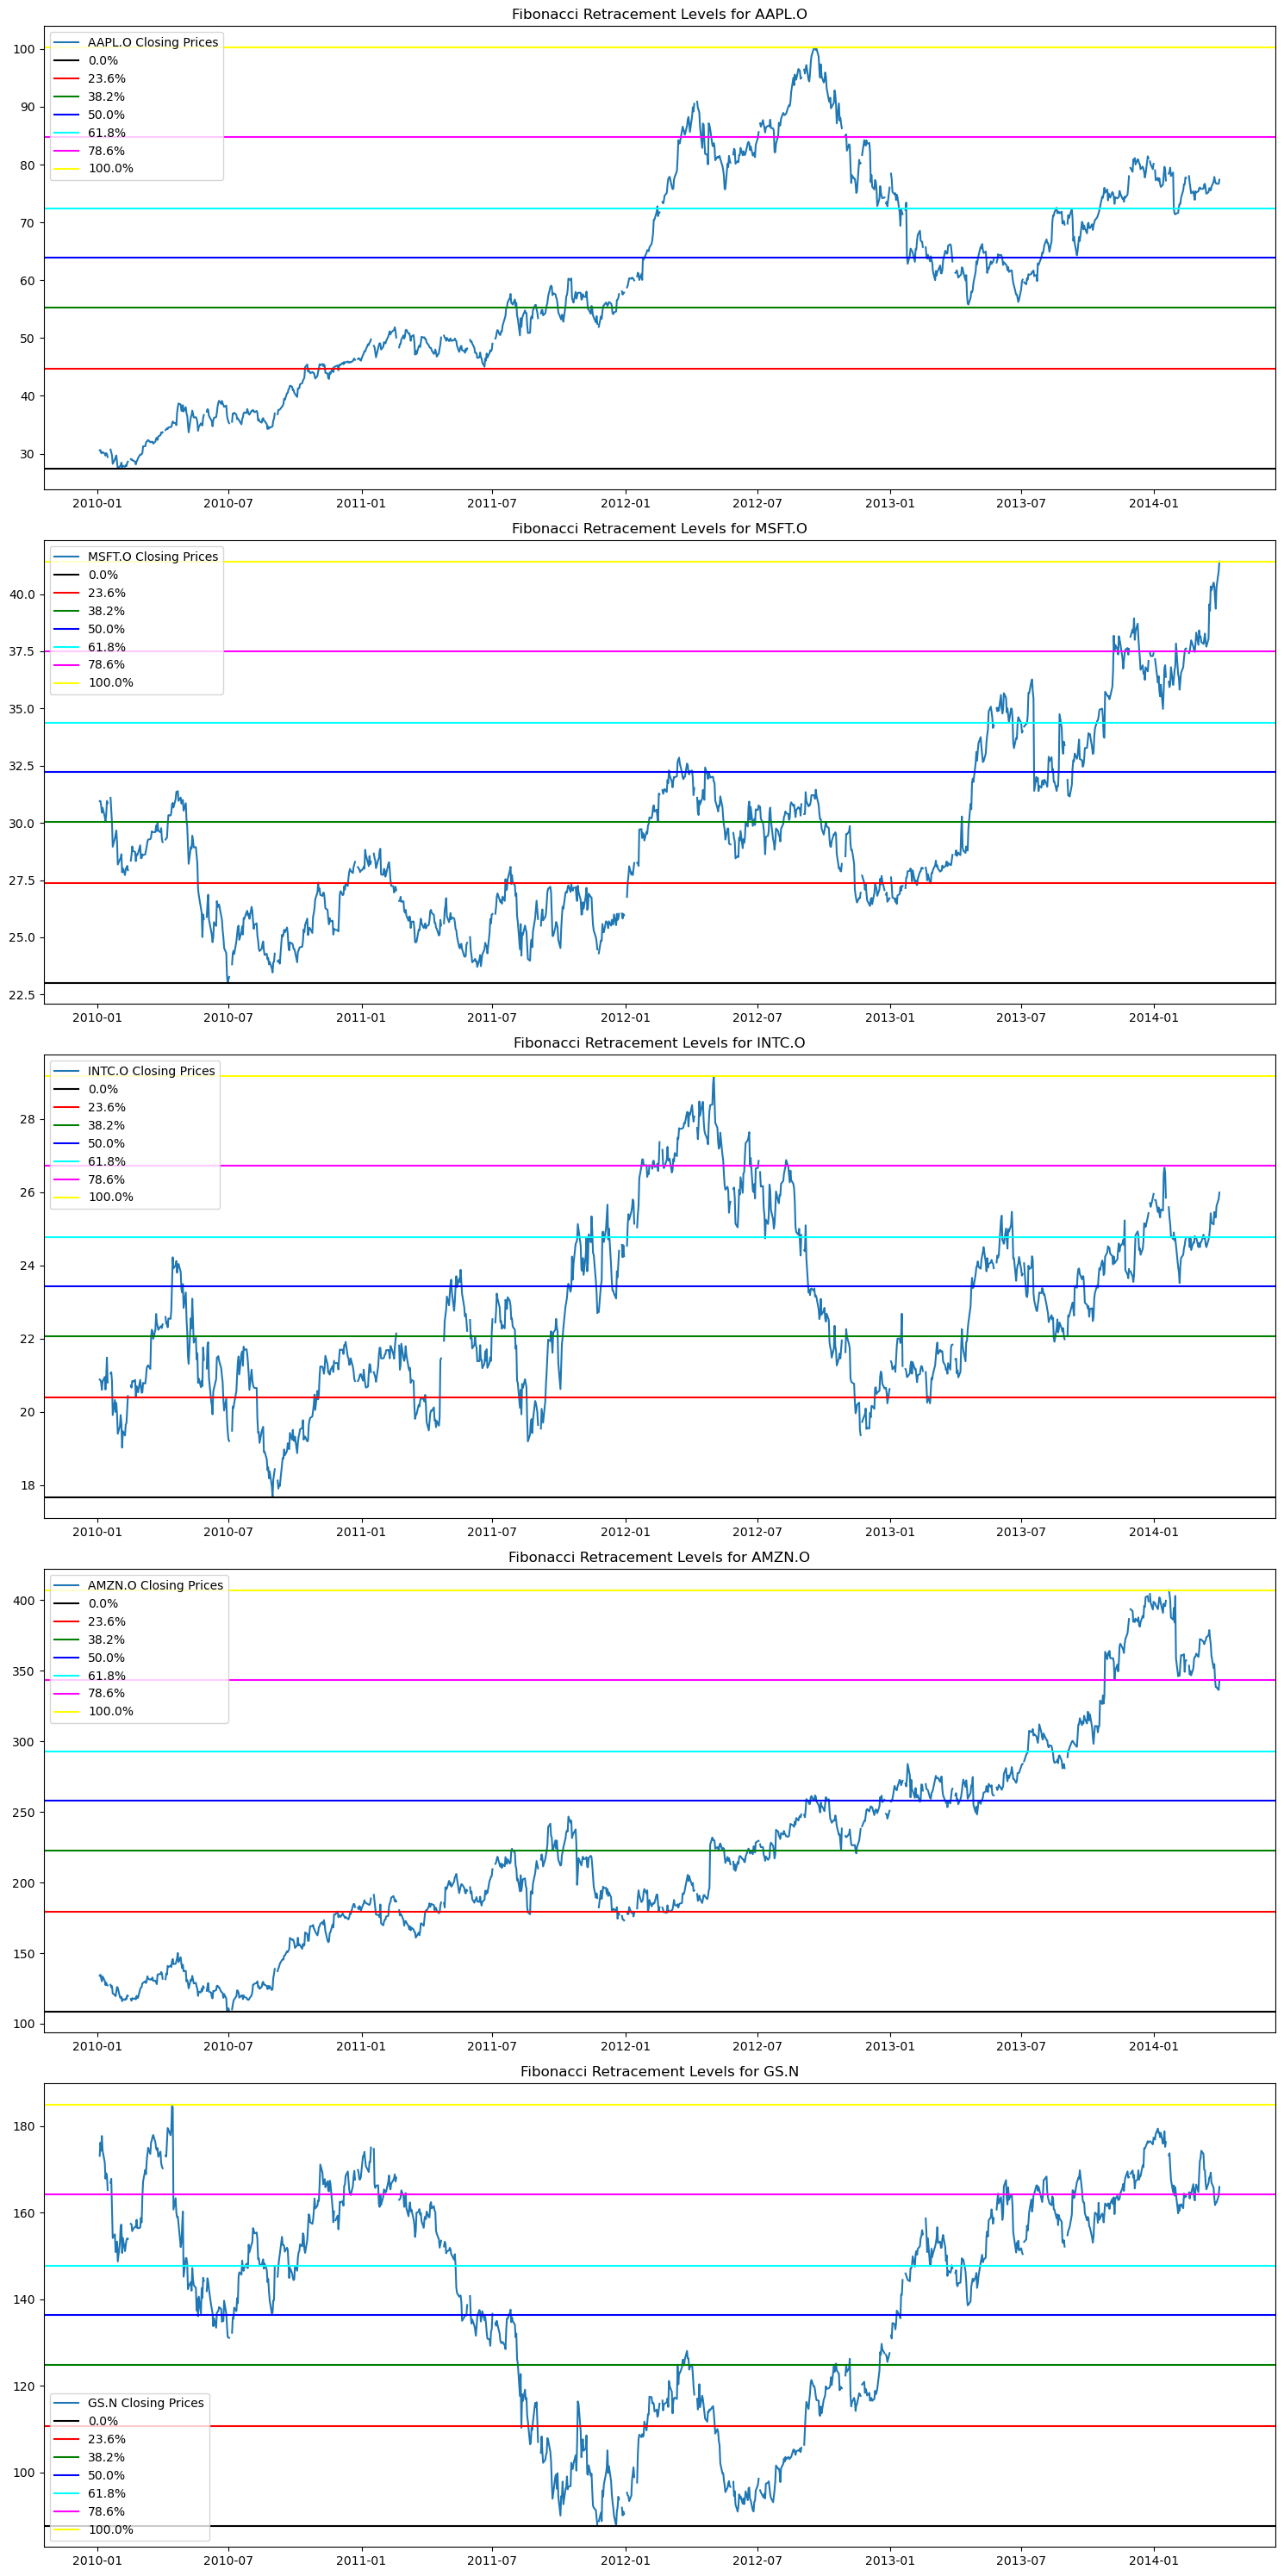

In [86]:
# Visualisation and exploration
# dict to store fib ranges
fib_ranges = {}
ratios = [0, 0.236, 0.382, 0.5 , 0.618, 0.786,1]
colors = ["black","r","g","b","cyan","magenta","yellow"]
for stock in stocks:

    levels = []
    max_level = train[stock].max()
    min_level = train[stock].min()
    for ratio in ratios:
        levels.append(min_level + (max_level-min_level)*ratio)
    fib_ranges[stock] = levels
       
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

for i, stock in enumerate(stocks):  # Iterate through each stock with its index
    axes[i].plot(train.index, train[stock], label=f'{stock} Closing Prices')  # Plot the closing prices for each stock
    axes[i].set_title(f'Fibonacci Retracement Levels for {stock}')
    
    for j, level in enumerate(fib_ranges[stock]):
        # Correctly call axhlines on each subplot axis object
        axes[i].axhline(level, label="{:.1f}%".format(ratios[j]*100), color=colors[j], linestyle="-")

    axes[i].legend()

plt.tight_layout()
plt.show()


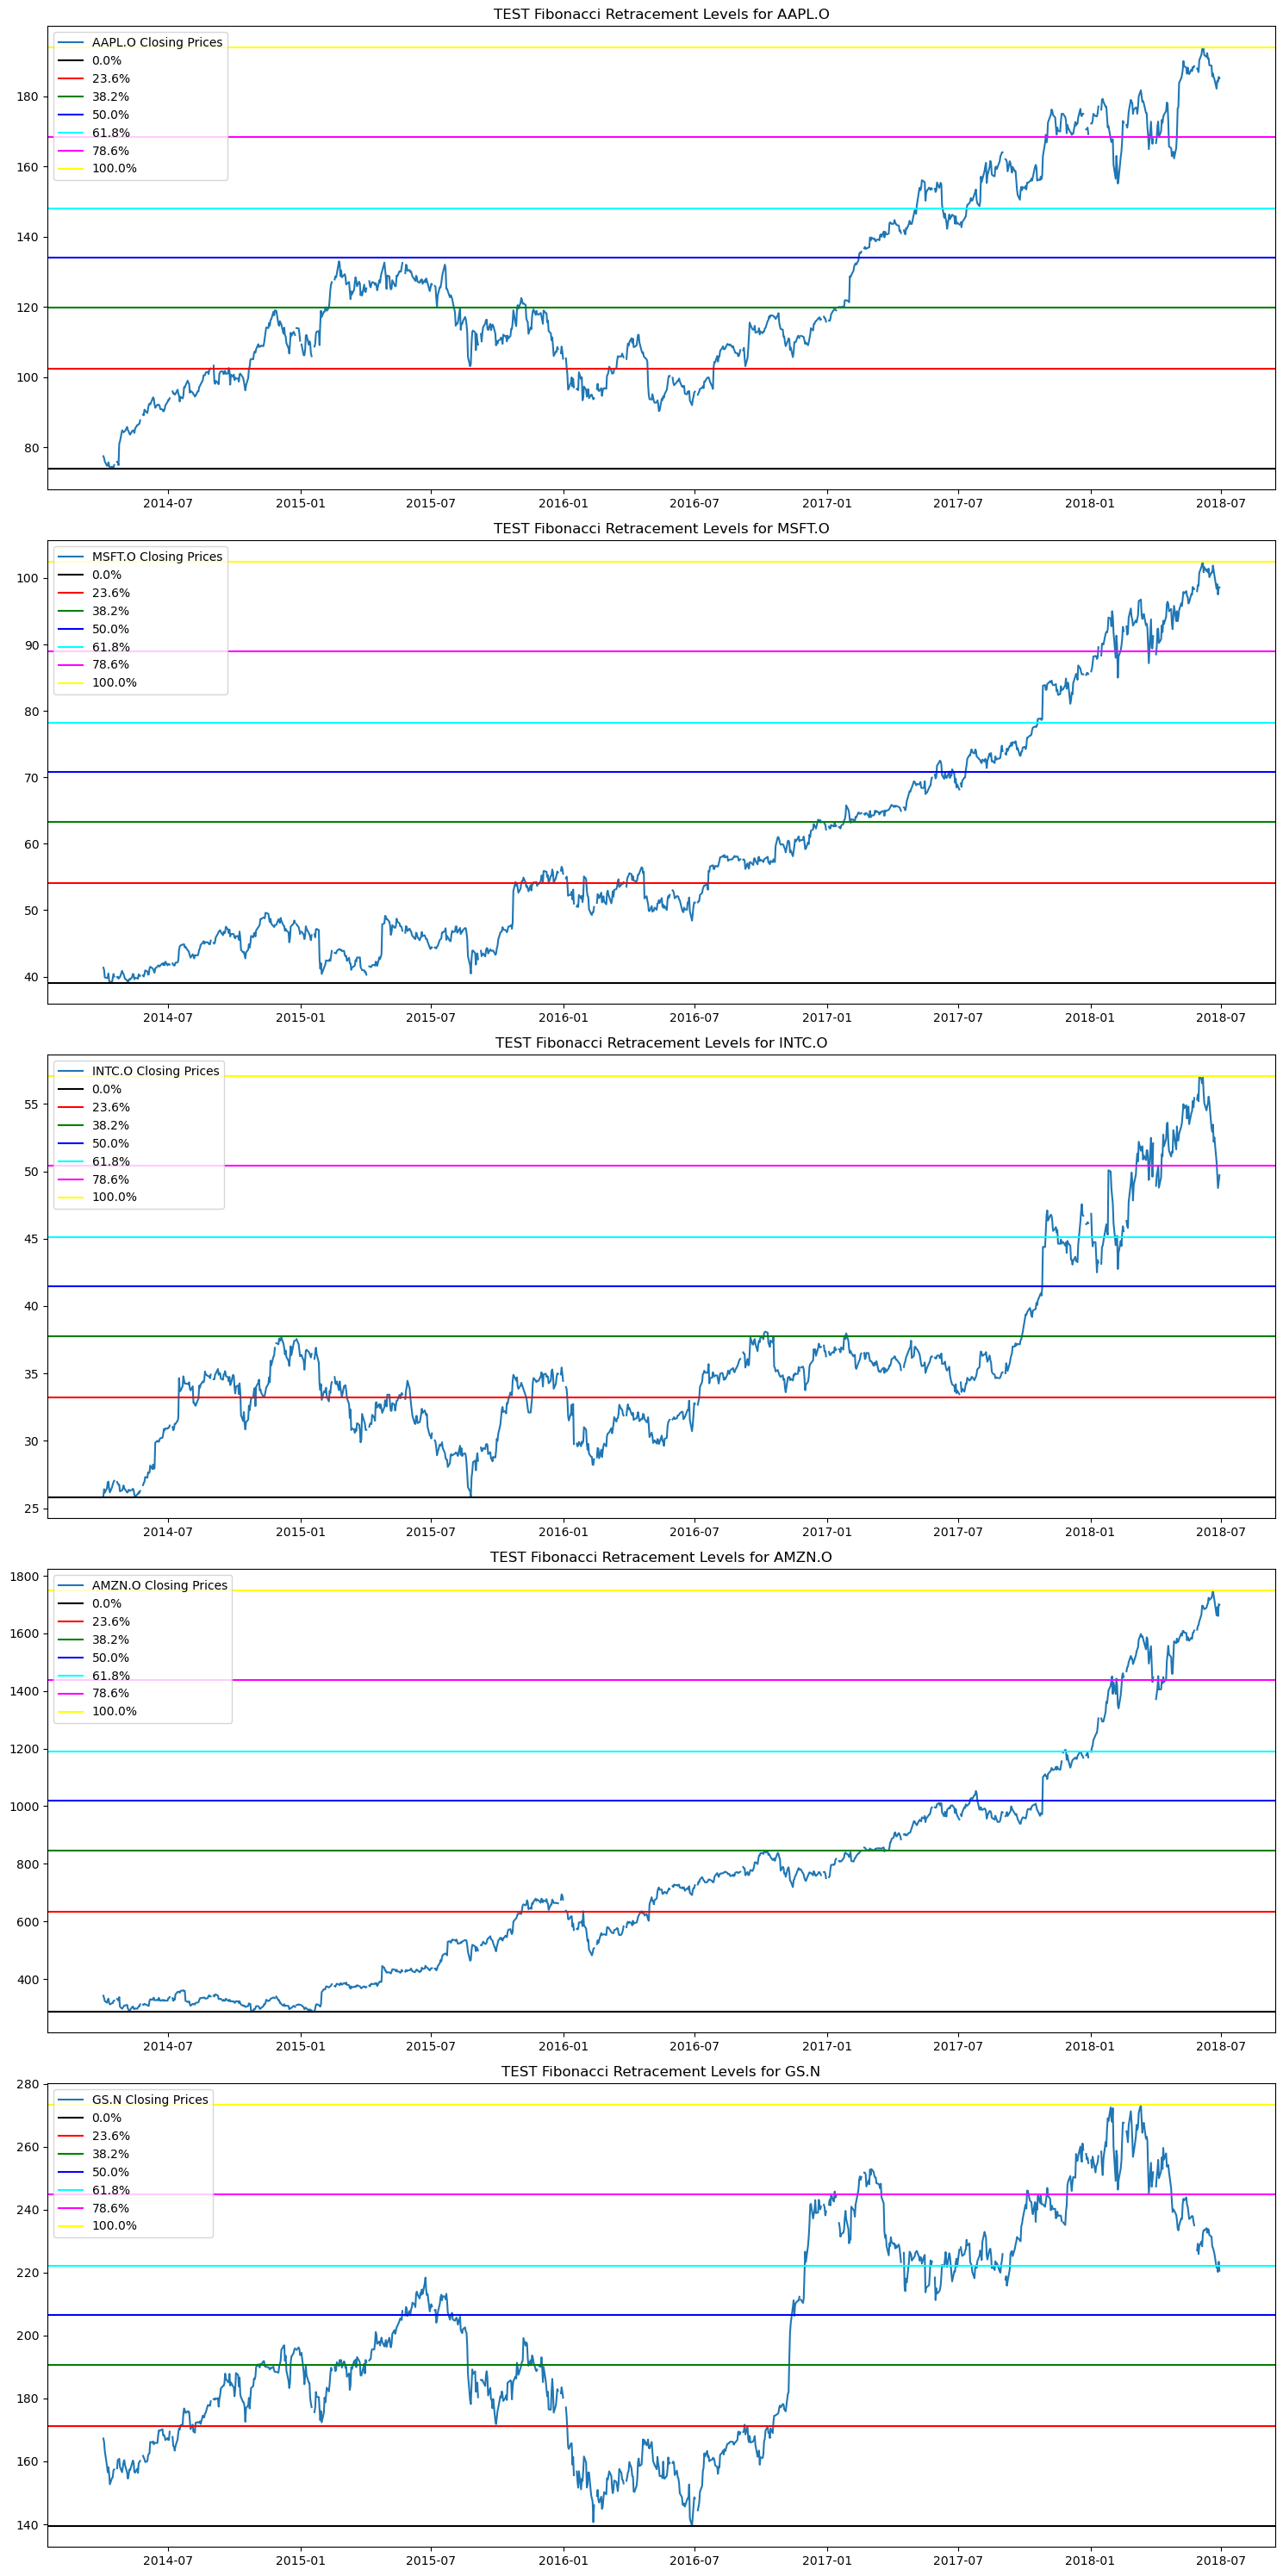

In [118]:
# Visualisation and exploration
# dict to store fib ranges
fib_ranges = {}
ratios = [0, 0.236, 0.382, 0.5 , 0.618, 0.786,1]
colors = ["black","r","g","b","cyan","magenta","yellow"]
for stock in stocks:

    levels = []
    max_level = test[stock].max()
    min_level = test[stock].min()
    for ratio in ratios:
        levels.append(min_level + (max_level-min_level)*ratio)
    fib_ranges[stock] = levels
       
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

for i, stock in enumerate(stocks):  # Iterate through each stock with its index
    axes[i].plot(test.index, test[stock], label=f'{stock} Closing Prices')  # Plot the closing prices for each stock
    axes[i].set_title(f'TEST Fibonacci Retracement Levels for {stock}')
    
    for j, level in enumerate(fib_ranges[stock]):
        # Correctly call axhlines on each subplot axis object
        axes[i].axhline(level, label="{:.1f}%".format(ratios[j]*100), color=colors[j], linestyle="-")

    axes[i].legend()

plt.tight_layout()
plt.show()


In [138]:
# PARAMETER TUNING
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# DataFrame for tracking trades
def calculate_fib_levels(max_price, min_price):
    ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    return [min_price + (max_price - min_price) * ratio for ratio in ratios]

trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])


def fibonacci_retracement(window, sell_level):
    holding_stock = [False] * len(stocks)
    entry_price = [0] * len(stocks)
    next_level_up = [None] * len(stocks)
    # store trades
    trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])
    # Adjusting to use a rolling window for weekly high/low for Fibonacci level calculation
    for stock_num, stock in enumerate(stocks):
        for date, current_close in train[stock].items():
            recent_window = train[stock].loc[date - pd.Timedelta(days=window):date]
            max_price = recent_window.max()
            min_price = recent_window.min()
        
            # Recalculate Fib levels based on new max and min
            fib_levels = calculate_fib_levels(max_price, min_price)
            
            if not holding_stock[stock_num]:
                # Buy logic based on updated fib levels
                for i, level in enumerate(fib_levels[:-1]):  # Exclude the last level
                    if current_close < level:
                        holding_stock[stock_num] = True
                        entry_price[stock_num] = current_close
                        buy_date = date
                        next_level_up[stock_num] = fib_levels[i + sell_level] if i + sell_level < len(fib_levels) else None
                        break
            else:
                # Sell logic based on the next Fibonacci level up
                if next_level_up[stock_num] and current_close > next_level_up[stock_num]:
                    sell_price = current_close
                    sell_date = date
                    trades = pd.concat([trades, pd.DataFrame({
                        'Stock': stock,
                        'Buy Date': buy_date,
                        'Buy Price': entry_price[stock_num],
                        'Sell Date': sell_date,
                        'Sell Price': sell_price
                    }, index=[0])], ignore_index=True)
                    holding_stock[stock_num] = False  # Reset position
                    entry_price[stock_num] = 0
                    next_level_up[stock_num] = None

    # Ensure you exit any remaining positions at the end of the period
    for i, stock in enumerate(stocks):
        if holding_stock[i]:
            sell_date = train.index[-1]
            sell_price = train[stock].iloc[-1]
            trades = pd.concat([trades, pd.DataFrame({
                'Stock': stock,
                'Buy Date': buy_date,
                'Buy Price': entry_price[i],
                'Sell Date': sell_date,
                'Sell Price': sell_price
            }, index=[0])], ignore_index=True)
    total_return = (np.sum(trades['Sell Price']) / np.sum(trades['Buy Price'])) - 1
    strategy_return = total_return * 252 / len(train)

    return strategy_return



In [142]:
best_window, best_level, best_return = None, None, 0
windows = range(1, 500)
levels = range(1, 6)
for w in windows:
    for l in levels:
        performance = fibonacci_retracement(w, l)
        if performance > best_return:
            best_window, best_level = w, l
            best_returns = performance
print("Best return is: ", best_return)
print("Best window size is: ", best_window)
print("Best profit taking level is: ", best_level)


Best return is:  0
Best window size is:  499
Best profit taking level is:  5


In [100]:
data.dropna(inplace=True)
benchmark_returns = ((np.sum(test.iloc[-1]) / np.sum(test.iloc[0])) - 1) * 252 / len(test)
benchmark_returns

/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_46326/3656046195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


0.5563782968323068

In [88]:
data['MSFT.O']

Date
2010-01-04    30.950
2010-01-05    30.960
2010-01-06    30.770
2010-01-07    30.452
2010-01-08    30.660
               ...  
2018-06-25    98.390
2018-06-26    99.080
2018-06-27    97.540
2018-06-28    98.630
2018-06-29    98.610
Name: MSFT.O, Length: 2138, dtype: float64

In [103]:
# # DataFrame for tracking trades
# trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])

# def calculate_fib_levels(max_price, min_price):
#     ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
#     return [min_price + (max_price - min_price) * ratio for ratio in ratios]

# holding_stock = [False] * 5
# entry_price = [0] * 5
# for stock_num, stock in enumerate(stocks):
#     max_price = train[stock].max()
#     min_price = train[stock].min()
#     fib_levels = calculate_fib_levels(max_price, min_price)

#     for date, current_close in test[stock].items():
#         # Update Fibonacci levels if new high or low is observed
#         if current_close > max_price:
#             max_price = current_close
#             fib_levels = calculate_fib_levels(max_price, min_price)
#         elif current_close < min_price:
#             min_price = current_close
#             fib_levels = calculate_fib_levels(max_price, min_price)
            
#         if not holding_stock[stock_num]:
#             # Buy logic based on updated fib levels
#             for i, level in enumerate(fib_levels[:-1]):  # Exclude the last level
#                 if current_close < level:
#                     holding_stock[stock_num] = True
#                     entry_price[stock_num] = current_close
#                     buy_date = date
#                     next_level_up = fib_levels[i + 1] if i + 1 < len(fib_levels) else None
#                     break
#         else:
#             # Sell logic based on the next Fibonacci level up
#             if next_level_up and current_close > next_level_up:
#                 sell_price = current_close
#                 sell_date = date
#                 trades = pd.concat([trades, pd.DataFrame({
#                     'Stock': stock,
#                     'Buy Date': buy_date,
#                     'Buy Price': entry_price[stock_num],
#                     'Sell Date': sell_date,
#                     'Sell Price': sell_price
#                 }, index=[0])], ignore_index=True)
#                 holding_stock[stock_num] = False  # Reset position
#                 entry_price[stock_num] = 0

# # Ensure you exit any remaining positions at the end of the period
# for i, stock in enumerate(stocks):
#     if holding_stock[i]:
#         sell_date = test.index[-1]
#         sell_price = test[stock].iloc[-1]
#         trades = pd.concat([trades, pd.DataFrame({
#             'Stock': stock,
#             'Buy Date': buy_date,
#             'Buy Price': entry_price[i],
#             'Sell Date': sell_date,
#             'Sell Price': sell_price
#         }, index=[0])], ignore_index=True)

# print(trades)


     Stock   Buy Date   Buy Price  Sell Date  Sell Price
0   AAPL.O 2014-04-02   77.507065 2014-08-19      100.53
1   AAPL.O 2015-08-21  105.760000 2017-02-13      133.29
2   MSFT.O 2015-01-27   42.660000 2015-10-23       52.87
3   MSFT.O 2016-02-09   49.280000 2016-07-22       56.57
4   INTC.O 2014-04-02   25.890000 2014-06-13       29.87
5   INTC.O 2014-10-13   31.470000 2014-11-20       35.95
6   INTC.O 2015-01-30   33.040000 2016-09-30       37.75
7   INTC.O 2016-11-04   33.610000 2017-10-02       39.04
8   INTC.O 2018-02-08   42.750000 2018-03-06       50.71
9   AMZN.O 2014-04-02  341.960000 2015-04-24      445.10
10  AMZN.O 2016-02-02  552.100000 2016-05-10      703.07
11    GS.N 2014-04-04  163.240000 2014-09-18      187.89
12    GS.N 2015-01-28  173.050000 2015-04-14      197.72
13    GS.N 2015-08-21  187.740000 2016-11-30      219.29
14    GS.N 2017-04-18  215.590000 2017-12-12      257.68
15    GS.N 2018-05-03  233.410000 2018-06-29      220.57


/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_46326/1072932470.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trades = pd.concat([trades, pd.DataFrame({


In [146]:

# DataFrame for tracking trades
trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])

def calculate_fib_levels(max_price, min_price):
    ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    return [min_price + (max_price - min_price) * ratio for ratio in ratios]

holding_stock = [False] * len(stocks)
entry_price = [0] * len(stocks)
next_level_up = [None] * len(stocks)

# Adjusting to use a rolling window for weekly high/low for Fibonacci level calculation
for stock_num, stock in enumerate(stocks):
    for date, current_close in test[stock].items():
        recent_window = test[stock].loc[date - pd.Timedelta(days=499):date]
        max_price = recent_window.max()
        min_price = recent_window.min()
    
        # Recalculate Fib levels based on new max and min
        fib_levels = calculate_fib_levels(max_price, min_price)
        
        if not holding_stock[stock_num]:
            # Buy logic based on updated fib levels
            for i, level in enumerate(fib_levels[:-1]):  # Exclude the last level
                if current_close < level:
                    holding_stock[stock_num] = True
                    entry_price[stock_num] = current_close
                    buy_date = date
                    next_level_up[stock_num] = fib_levels[i + 3] if i + 3 < len(fib_levels) else None
                    break
        else:
            # Sell logic based on the next Fibonacci level up
            if next_level_up[stock_num] and current_close > next_level_up[stock_num]:
                sell_price = current_close
                sell_date = date
                trades = pd.concat([trades, pd.DataFrame({
                    'Stock': stock,
                    'Buy Date': buy_date,
                    'Buy Price': entry_price[stock_num],
                    'Sell Date': sell_date,
                    'Sell Price': sell_price
                }, index=[0])], ignore_index=True)
                holding_stock[stock_num] = False  # Reset position
                entry_price[stock_num] = 0
                next_level_up[stock_num] = None

# Ensure you exit any remaining positions at the end of the period
for i, stock in enumerate(stocks):
    if holding_stock[i]:
        sell_date = test.index[-1]
        sell_price = test[stock].iloc[-1]
        trades = pd.concat([trades, pd.DataFrame({
            'Stock': stock,
            'Buy Date': buy_date,
            'Buy Price': entry_price[i],
            'Sell Date': sell_date,
            'Sell Price': sell_price
        }, index=[0])], ignore_index=True)
total_return = (np.sum(trades['Sell Price']) / np.sum(trades['Buy Price'])) - 1
strategy_return = total_return * 252 / len(test)
print(trades)
print(strategy_return)

    Stock   Buy Date   Buy Price  Sell Date   Sell Price
0  AAPL.O 2014-04-03   76.969923 2014-04-24    81.109919
1  MSFT.O 2014-04-03   41.010000 2014-06-06    41.480000
2  AMZN.O 2014-04-03  333.620000 2014-07-11   346.200000
3  AMZN.O 2014-07-25  324.010000 2015-02-02   364.470000
4    GS.N 2014-04-03  166.090000 2014-06-17   168.220000
5  AAPL.O 2014-07-08   96.260000 2018-06-29   185.110000
6  MSFT.O 2014-07-08   40.860000 2018-06-29    98.610000
7  INTC.O 2014-07-08   26.160000 2018-06-29    49.710000
8  AMZN.O 2014-07-08  463.370000 2018-06-29  1699.800000
9    GS.N 2014-07-08  164.910000 2018-06-29   220.570000
0.1997181080348704


In [91]:
# trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])

# for stock in stocks:
#     in_position = False
#     buy_price = None
#     buy_date = None
#     sell_price = None
#     sell_date = None
#     next_level_up = None

#     for date, current_close in test[stock].items():
#         if not in_position:
#             # Check if current close crossed any Fib level downwards
#             for i, level in enumerate(fib_ranges[stock][:-1]):  # Exclude the last level to ensure a next level exists
#                 if current_close < level and not in_position:
#                     # This simulates a buy signal
#                     in_position = True
#                     buy_price = current_close
#                     buy_date = date
#                     next_level_up = fib_ranges[stock][i + 1]  # Next Fibonacci level for the sell condition
#                     break  # Break after entering position
#         else:
#             # Check if current close is above the next Fibonacci level to sell
#             if current_close > next_level_up:
#                 sell_price = current_close
#                 sell_date = date
#                 trades = pd.concat([trades, pd.DataFrame({
#                     'Stock': stock, 
#                     'Buy Date': buy_date, 
#                     'Buy Price': buy_price, 
#                     'Sell Date': sell_date, 
#                     'Sell Price': sell_price
#                 }, index=[0])], ignore_index=True)
#                 in_position = False  # Reset position

# # Ensure you exit any remaining positions at the end of the period
# for stock in stocks:
#     if in_position:
#         # Assuming we close the position on the last available date at the last available price
#         sell_date = test.index[-1]
#         sell_price = test[stock].iloc[-1]
#         trades = pd.concat([trades, pd.DataFrame({
#             'Stock': stock, 
#             'Buy Date': buy_date, 
#             'Buy Price': buy_price, 
#             'Sell Date': sell_date, 
#             'Sell Price': sell_price
#         }, index=[0])], ignore_index=True)
# trades

In [98]:
total_return = (np.sum(trades['Sell Price']) / np.sum(trades['Buy Price'])) - 1
strategy_return = total_return * 252 / len(test)
strategy_return

0.5596519306086757